In [1]:
import numpy as np
import numpy.linalg as npl
import sympy
from sympy import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, art3d
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Circle
from matplotlib.patches import Ellipse
from IPython.core.interactiveshell import InteractiveShell
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D

In [3]:
InteractiveShell.ast_node_interactivity = "all"
plt.rcParams[ "figure.figsize" ] = (10,10)

# Chapter 07, Continuous Optimization

In [4]:
linspace = np.linspace(-6,2,1000)
x = Symbol("x")
f = x**4 + 7*x**3 + 5 * x**2 - 17*x + 3
fLam = lambdify('x',f)
f
fLam(1)

x**4 + 7*x**3 + 5*x**2 - 17*x + 3

-1

In [5]:
f2 = diff(f)
f2Lam = lambdify('x',f2)
f2
f2Lam(1)

4*x**3 + 21*x**2 + 10*x - 17

18

From here we are looking for the stationary points. These are the points where the slope, or derivative, or gradient, plateus, flattens, or is close to 0. There are several ways to solve this in python. Symbolically, with SymPy, algorithmically by checking all xs in an array, and with SciPy's `fsolve`.

In [6]:
simplify(solve(f2)[0])

3**(2/3)*(107/6 + (-42 + (1 + sqrt(3)*I)*(1809 + 12*sqrt(206970)*I)**(1/3))*(1 + sqrt(3)*I)*(1809 + 12*sqrt(206970)*I)**(1/3)/72)/((1 + sqrt(3)*I)*(603 + 4*sqrt(206970)*I)**(1/3))

This approach is not very fruitful because square and cube roots of negative values leads us to complex numbers.

In [7]:
ys = f2Lam(linspace)
ys[:5]
ivs = np.vstack([[ind,val] for ind,val in enumerate(ys)])
ivs[:5]
[i for i in ivs if (abs(i[1] - 0) < .115)] # Return if within tolerance.
linspace[190], linspace[570], linspace[832]

array([-185.        , -183.48174696, -181.97002267, -180.46481481,
       -178.96611105])

array([[   0.        , -185.        ],
       [   1.        , -183.48174696],
       [   2.        , -181.97002267],
       [   3.        , -180.46481481],
       [   4.        , -178.96611105]])

[array([1.90000000e+02, 1.12132446e-01]),
 array([5.70000000e+02, 8.49036413e-02]),
 array([8.32000000e+02, 1.21430176e-02])]

(-4.478478478478479, -1.4354354354354353, 0.6626626626626626)

This approach works but is computationally expensive, and requires fine-tuning in the tolerance.

In [8]:
from scipy.optimize import fsolve

In [9]:
derivedSols = np.vstack([ fsolve(f2Lam,-4), fsolve(f2Lam,-1), fsolve(f2Lam,0) ])
Matrix(derivedSols)

Matrix([
[-4.48026848037364],
[-1.43211239686132],
[0.662380877234966]])

This approach works and is relatively cost effective but requires that you are able to make guesses. 

We are now looking for whether these stationary points are maximums or minimums. So we plug the above values into our second derivative. If we have a value less than zero, it is a maximum, else, minimum. 

In [10]:
f3 = diff(f2)
f3Lam = lambdify('x',f3)
f3
minsMaxs = np.hstack([np.vstack([f3Lam(derivedSols[0]), f3Lam(derivedSols[1]), f3Lam(derivedSols[2])]),
           [f3Lam(derivedSols[0]) < 0 ,f3Lam(derivedSols[1]) < 0 ,f3Lam(derivedSols[2]) < 0]])
Matrix(minsMaxs)

12*x**2 + 42*x + 10

Matrix([
[62.7023916990616, 0.0],
[-25.537369661249, 1.0],
[43.0849779621873, 0.0]])

The above tells us that there are two minima, and one maxima. 
#### Figure 7.2

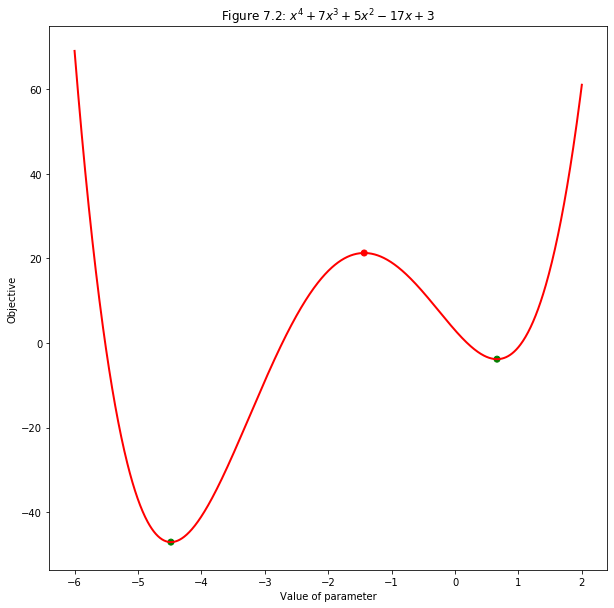

In [11]:
plt.plot(linspace,fLam(linspace), c = "r", lw = 2)
colors = ["g" if i == 0 else "r" for i in minsMaxs[:,1]]
plt.scatter(derivedSols,fLam(derivedSols), c = colors)
plt.xlabel("Value of parameter")
plt.ylabel("Objective")
plt.title("Figure 7.2: " + r"$x^4 + 7x^3 + 5x^2 - 17x + 3$");

Convex functions are unlike the above in that the local = global minimum/maximum.

## 7.1 Optimization using Gradient Descent
*Solving for the minimum of a real valued function. A derivative might tell us what direction to move, but will not tell us how far to move.*

In [66]:
x = Symbol('x')
y = Symbol('y')
f = (np.dot((1/2)*np.array([x,y]),np.dot(np.vstack([[2,1],[1,20]]),np.vstack([x,y]))) - np.dot(np.array([5,3]),np.vstack([x,y])))[0]
f = simplify(f)
fLam = lambdify('x,y',f)
f
fLam(2,2)

1.0*x**2 + 1.0*x*y - 5.0*x + 10.0*y**2 - 3.0*y

32.0

In [67]:
scale3D = 4
n = 150
linspace = np.linspace(-scale3D,scale3D,n) 
X,Y = np.meshgrid(linspace,linspace)
Z = fLam(X,Y)
point = np.vstack([-3,-1])
np.shape(X), np.shape(Y), np.shape(Z)
point

((150, 150), (150, 150), (150, 150))

array([[-3],
       [-1]])

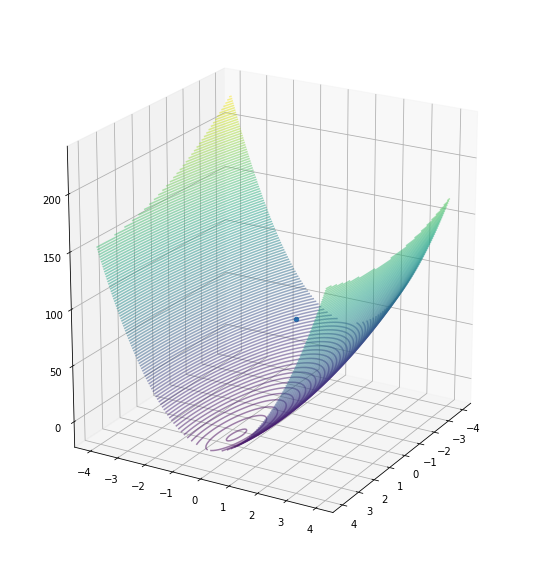

In [68]:
fig = plt.figure(figsize = (15,16), tight_layout = True)
gs = GridSpec(2, 2)
ax = fig.add_subplot(gs[1,0], projection='3d')
ax.contour3D(X,Y,Z, n, alpha = .5)

ax.scatter3D(point[0],point[1],fLam(*point))
ax.view_init(20, 30);

From here we can use the derivative to inform the direction to move.

In [69]:
f

1.0*x**2 + 1.0*x*y - 5.0*x + 10.0*y**2 - 3.0*y

The book notes the following method of constructing the derivative, composed of partial derivatives.

In [70]:
np.dot(np.array([x,y]),np.vstack([[2,1],[1,20]]))-np.array([5,3])

array([2*x + y - 5, x + 20*y - 3], dtype=object)

Which can also be deduced via `SymPy`.

In [71]:
f1x = f.diff(x)
f1xLam = lambdify('x,y',f1x)
f1y = f.diff(y)
f1yLam = lambdify('x,y',f1y)
f1 = [f1x,f1y]
f1
f1Lam = lambdify('x,y',f1)
f1Lam(*point)

[2.0*x + 1.0*y - 5.0, 1.0*x + 20.0*y - 3.0]

[array([-12.]), array([-26.])]

We then use (7.6): $ x_{i+1} = x_i - \gamma_i ((\nabla f) (x_i))^T.$ Which is just the value of x for our function to go to. These values are built with an initial guess $x_i$, and a step $\gamma$ which takes in our derivative and our initial guess if it is the first iteration, and the last guess if any other iteration, and subtracts it from our initial or last guess.

We can implement this as a function that takes in an array of partial derivatives and an initial guess, and iterates.

In [72]:
def gradientDescent(gradient, point, gamma = .085, epsilon = .01, maxIter = 3000, initError = 10):
    # Initializing iteration.
    x,y = point.astype(float)
    currIter, iterCoords = 0, [np.hstack([x,y])]
    error = initError
    currX = np.array([x,y])
    # Initializing iteration.
    
    while npl.norm(error) > epsilon and currIter<maxIter:
        currIter+=1 # Increment counter.
        prevX = currX.copy() # Track last X values for error.
        
        # Gradient descent equation
        currX -= gamma * np.array(gradient(x,y)) # New X = (last) minus (step size * function gradient(last)).
        x,y = currX[0].copy(), currX[1].copy() # Update X.
        # Gradient descent equation
        
        error = currX - prevX # Error based on how much movement new X made based on gamma and gradient.
        iterCoords.append(np.hstack([x,y])) # Track X for plotting.
        
    return currIter, currX, np.vstack(iterCoords)

In [73]:
finalIterCount, finalCoord, iterCoords = gradientDescent(f1Lam,point)
finalIterCount
finalCoord
iterCoords[:5]

26

array([[2.43780903],
       [0.02822684]])

array([[-3.        , -1.        ],
       [-1.98      ,  1.21      ],
       [-1.32125   , -0.4237    ],
       [-0.635623  ,  0.66389625],
       [-0.15899827, -0.15569942]])

#### Figure 7.3 
*Gradient descent on a two-dimensional surface (shown as a heatmap).*

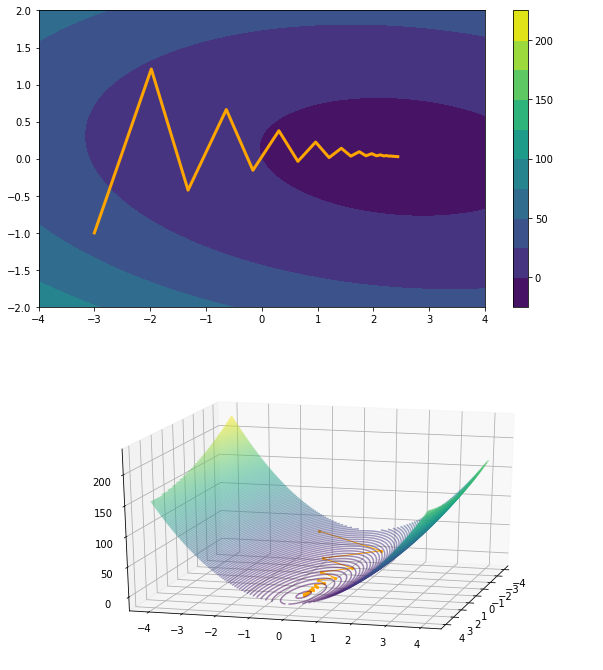

In [87]:
fig = plt.figure(figsize=(10,12))

ax = fig.add_subplot(2, 1, 1)
plt.contourf(X,Y,Z, levels=10)
plt.colorbar()
plt.plot(iterCoords[:,0],iterCoords[:,1], lw = 3, c = "orange")
plt.axis([-4,4,-2,2]);

ax = fig.add_subplot(2, 1, 2, projection='3d')
n = 150
ax.contour3D(X,Y,Z, n, alpha = .5)

for i in iterCoords:
    pointTemp = i
    ax.scatter3D(pointTemp[0],pointTemp[1],fLam(*pointTemp),c = "orange", s = 5)
ax.plot(iterCoords[:,0],iterCoords[:,1],fLam(iterCoords[:,0],iterCoords[:,1]), c = "orange", lw = 1)
ax.view_init(20, 15);

Note the difference with a smaller step size. 

In [88]:
finalIterCount, finalCoord, iterCoords = gradientDescent(f1Lam,point, gamma = .01)
finalIterCount
finalCoord
iterCoords[:5]

121

array([[1.98420608],
       [0.05349828]])

array([[-3.        , -1.        ],
       [-2.88      , -0.74      ],
       [-2.765     , -0.5332    ],
       [-2.654368  , -0.36891   ],
       [-2.54759154, -0.23858432]])

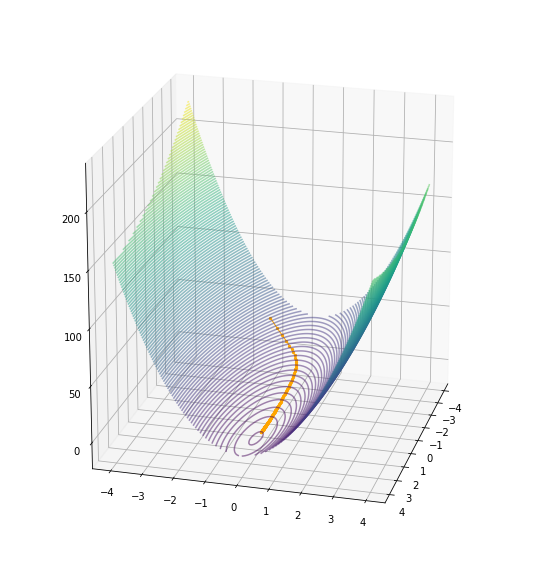

In [89]:
fig = plt.figure(figsize = (15,16), tight_layout = True)
gs = GridSpec(2, 2)
n = 150
ax = fig.add_subplot(gs[1,0], projection='3d')
ax.contour3D(X,Y,Z, n, alpha = .5)

for i in iterCoords:
    pointT = i
    ax.scatter3D(pointT[0],pointT[1],fLam(*pointT),c = "orange", s = 5)
ax.plot(iterCoords[:,0],iterCoords[:,1],fLam(iterCoords[:,0],iterCoords[:,1]), c = "orange", lw = 1)
ax.view_init(20, 15);

At this point the book notes two heuristics for selecting a step-size. 

1. When the function value increases, the step-size was too large, undo step and decrease step-size.
1. Inversely, when the function value decreases, the step-size could have been larger, increase step-size.

*(By how much to decrease/increase step size, is not mentioned.)*

### Example 7.2
*Book notes the use of the Euclidean norm to minimize the error. See implementation above.*

##### 7.1.2 Gradient Descent With Momentum
*Momentum in this context is updating the next update based on the last as a linear combination.*
##### 7.1.3 Stochastic Gradient Descent
*Because calculating a gradient is computationally non-trivial, it is sometimes best to approximate the gradient. In order to work with a noise gradient, we implement a "loss function", which reduces our error, and takes in batches of the data at a time. Assuming that our approximation is unbiased, we can assume that working with batches is sufficient to yield convergence. This method is called Stochastic Gradient Descent.*

## 7.2 Constrainted Optimization and Lagrange Multipliers
#### Figure 7.4
*Illustration of constrained optimization. The unconstrainted problem has a minimum on the right side. The box constraints require that the optimal solution is within the box, resulting in an optimal value.*

In [24]:
finalIterCount, finalCoord, iterCoords = gradientDescent(f1Lam,point)
finalIterCount
finalCoord
iterCoords[:5]

26

array([[2.43780903],
       [0.02822684]])

array([[-3.        , -1.        ],
       [-1.98      ,  1.21      ],
       [-1.32125   , -0.4237    ],
       [-0.635623  ,  0.66389625],
       [-0.15899827, -0.15569942]])

In [25]:
bounds = [-1,1]

In [26]:
iTemp = np.vstack([i for i in iterCoords if -1<=i[0] and i[0]<=1])
a = np.vstack([[ind,npl.norm(i)] for ind,i in enumerate(iTemp)])
minVal = iTemp[int(a[a[:,1].argsort()][::-1][0][0])]
minVal

array([0.96510292, 0.22469541])

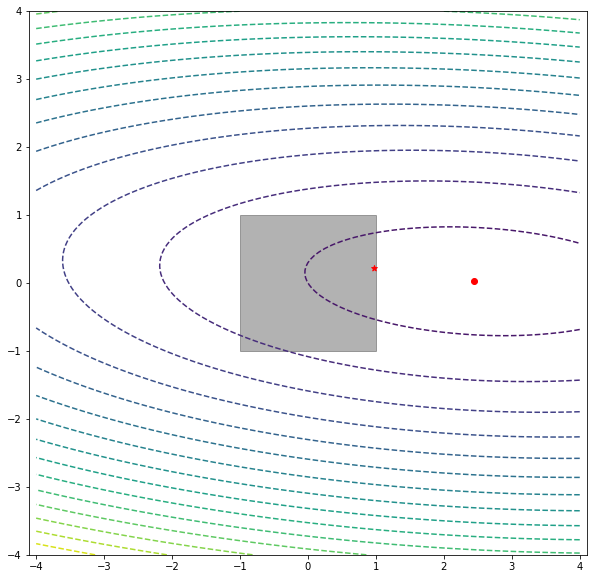

In [27]:
plt.contour(X,Y,Z, levels=20, linestyles = "dashed")
plt.fill_between(np.linspace(-1,1,100),np.linspace(-1,-1,100),np.linspace(1,1,100), alpha = .3, ec = 'k', fc = 'k')
plt.scatter(minVal[0],minVal[1], marker = "*", c = "r")
plt.scatter(finalCoord[0],finalCoord[1], marker = "o", c = "r")
plt.axis('equal');

Note that the above is not an implementation itself, of the lagrangian multiplier modified objective function. See 7.20 for the modifications to the objective, wherein $\mathcal{L}(x, \lambda) = f(x) - \lambda g(x).$

## 7.3 Convex Optimization
Convex problems are significant in that convex problems are much more straight forward for guaranteeing "global" optimality, that is, a local optimum = global optimum. Sometimes, a non-convex problem can be either broken up into convex problems, or completely reconfigured into a single convex problem.

#### Figure 7.5, 7.6 
*Book provides illustrations for convex and non-convex sets as epigraphs, wherein a convex set can have a line drawn between any two edge points, without another line intersecting.*

For the domain of -3.5 to 3.5, $x^2$ is convex, whereas $sin(x)$, is not. 

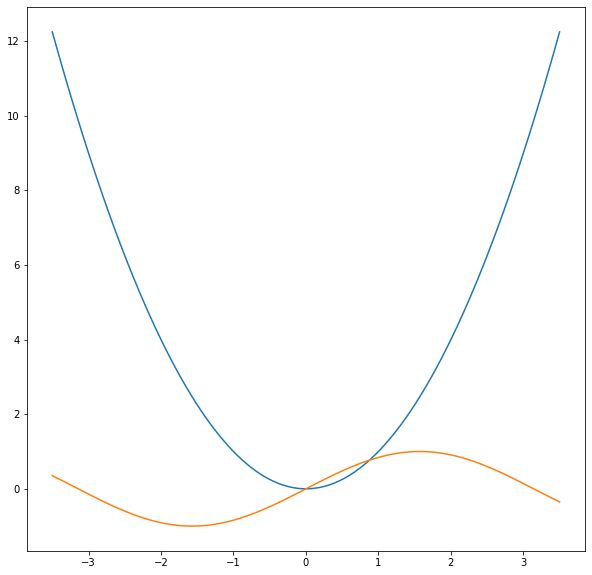

In [28]:
linspace = np.linspace(-3.5,3.5,100)
plt.plot(linspace,linspace**2)
plt.plot(linspace,np.sin(linspace))

#### Figure 7.7 
*Example of a convex function.*

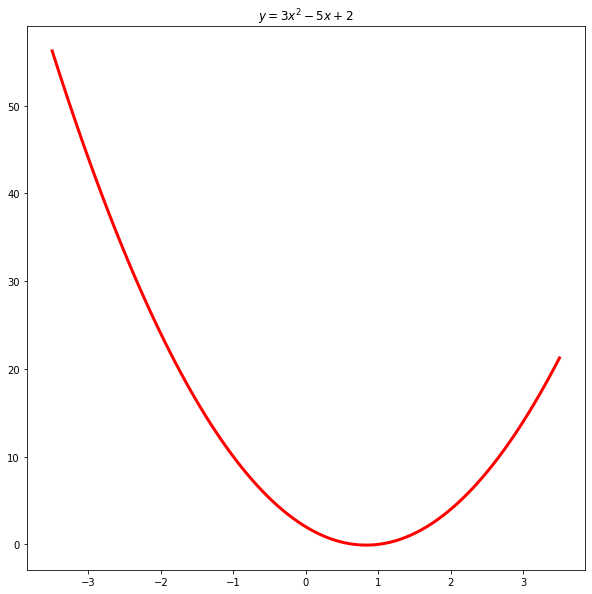

In [29]:
x = Symbol('x')
f = 3*x**2 - 5*x + 2
fLam = lambdify('x',f)
plt.plot(linspace,fLam(linspace), lw = 3, c = "r")
plt.title(r"$y = 3x^2 - 5x + 2$");

As the book notes, if a function is differentiable, we can verify convexity by checking if for any two points, it holds that $f(y) \geq f(x) + \nabla_xf(x)^T(y-x)$.

In [30]:
point = np.vstack([-3,-1])
point

array([[-3],
       [-1]])

In [31]:
fLam(point[1])

array([10])

In [32]:
f1 = diff(f)
f1Lam = lambdify('x',f1)
eq73rhs = lambda x,y: fLam(x) + f1Lam(x)*(y-x)
eq73rhs(*point)

array([-2])

The above should hold for any arbitrary $(x,y)$, and we can plot a few as below.

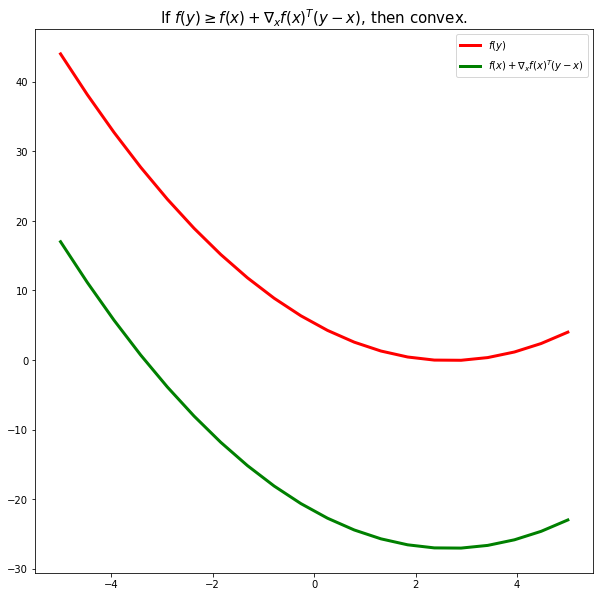

In [33]:
linspace = np.linspace(-5,5,20)
linspaceX = np.linspace(0,5,20)
linspaceY = np.linspace(-3,2,20)

plt.plot(linspace,fLam(linspaceY), 
        lw = 3, c = "r",
        label = r"$f(y)$")
plt.plot(linspace,eq73rhs(linspaceX,linspaceY), 
        lw = 3, c = "g",
        label = r"$f(x) + \nabla_xf(x)^T(y-x)$")
plt.legend(loc=1)
plt.title(r"If $f(y) \geq f(x) + \nabla_xf(x)^T(y-x)$, then convex.", size = 15);

### Example 7.3
#### Figure 7.8

In [34]:
from sympy.codegen.cfunctions import log2
point = np.vstack([2,4])
f = x*log2(x)
fLam = lambdify('x',f)
f1 = diff(f)
f1Lam = lambdify('x',f1)
f
f1
point

x*log2(x)

log2(x) + 1/log(2)

array([[2],
       [4]])

In [35]:
fLam(point[1])
eq73rhs(*point)

array([8.])

array([6.88539008])

Given the above to check eq 7.3, we can construct Figure 7.8 using the equation for a line for the tangent at x = 2.

In [38]:
point[0]
f
f1
lineYs = f1Lam(point[0])*(linspace - point[0]) + fLam(point[0])
lineYs

array([2])

x*log2(x)

log2(x) + 1/log(2)

array([-2.88539008, -2.2425756 , -1.59976111, -0.95694663, -0.31413214,
        0.32868234,  0.97149682,  1.61431131,  2.25712579,  2.89994028,
        3.54275476,  4.18556925,  4.82838373,  5.47119822,  6.1140127 ,
        6.75682718,  7.39964167,  8.04245615,  8.68527064,  9.32808512])

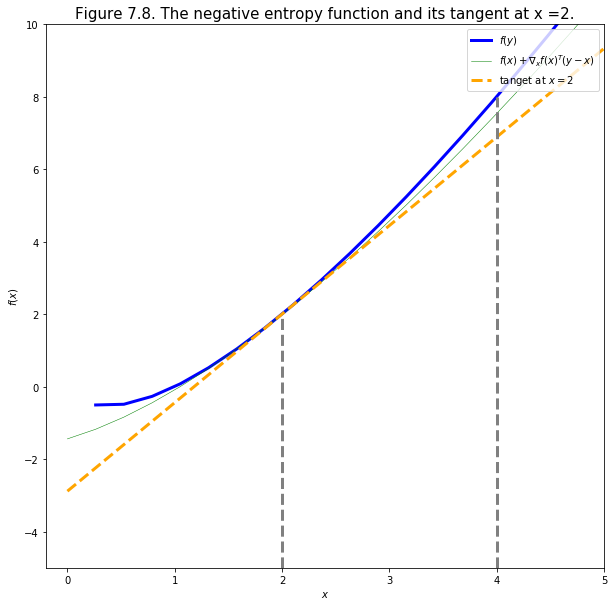

In [39]:
linspace = np.linspace(0,5,20)
linspaceY = np.linspace(0,5,20)
linspaceX = np.linspace(1,3,20)

plt.plot(linspace,fLam(linspaceY), 
        lw = 3, c = "b",
        label = r"$f(y)$")
plt.plot(linspace,eq73rhs(linspaceX,linspaceY), 
        lw = .5, c = "g",
        label = r"$f(x) + \nabla_xf(x)^T(y-x)$")
plt.plot(linspace,lineYs, c = "orange", linestyle = "dashed", lw = 3,
        label = r"tanget at $x = 2$")
plt.plot(np.linspace(point[0],point[0],10),np.linspace(-5,fLam(point[0]),10), c = "grey", linestyle = "dashed", lw = 3)
plt.plot(np.linspace(point[1],point[1],10),np.linspace(-5,fLam(point[1]),10), c = "grey", linestyle = "dashed", lw = 3)

plt.legend(loc=1)
plt.title(r"Figure 7.8. The negative entropy function and its tangent at x =2.", size = 15)
plt.axis([-.2,5,-5,10])
plt.xlabel(r"$x$"); plt.ylabel(r"$f(x)$");

# If this cell fails, re-run the cell before, multiplication with log sometimes causes an error.

### Example 7.4
*Book extends Defintion 7.3 to sums of weighted convex functions. That is, if $f(x)$ and $f_1(x)$ are convex, $f(x)+f_1(x)$ is convex, and $\alpha f(x)+\beta f_1(x)$ is convex.*

### Example 7.5 (Linear Program)
#### Figure 7.9
*Illustration of a linear program. The unconstrained problem (indicated by the contour lines) has a minimum on the right side. The optimal value given the constraints are shown by the star.*

In [40]:
# The following is constructed with guidance from the book and benalexkeen.com.
linspace = np.linspace(0,16,200)
X,Y = np.meshgrid(linspace,linspace)
x = Symbol('x')
y = Symbol('y')
Ztemp = -5*x+-3*y # Objective function is linear.
Z0 = lambdify('x,y', Ztemp)
Z = Z0(X,Y)
Z

array([[  -0.        ,   -0.40201005,   -0.8040201 , ...,  -79.1959799 ,
         -79.59798995,  -80.        ],
       [  -0.24120603,   -0.64321608,   -1.04522613, ...,  -79.43718593,
         -79.83919598,  -80.24120603],
       [  -0.48241206,   -0.88442211,   -1.28643216, ...,  -79.67839196,
         -80.08040201,  -80.48241206],
       ...,
       [ -47.51758794,  -47.91959799,  -48.32160804, ..., -126.71356784,
        -127.11557789, -127.51758794],
       [ -47.75879397,  -48.16080402,  -48.56281407, ..., -126.95477387,
        -127.35678392, -127.75879397],
       [ -48.        ,  -48.40201005,  -48.8040201 , ..., -127.1959799 ,
        -127.59798995, -128.        ]])

Optimizing in this example is simply a matter of calculating the Z-value given by our objective function, for each corner and selecting the maximum.

In [41]:
A = np.vstack([[2,2],[2,-4],[-2,1],[0,-1],[0,1]])
b = np.array([33,8,-5,-1,8])
Matrix(A)
Matrix(b)

Matrix([
[ 2,  2],
[ 2, -4],
[-2,  1],
[ 0, -1],
[ 0,  1]])

Matrix([
[33],
[ 8],
[-5],
[-1],
[ 8]])

In [42]:
node0 = npl.solve(np.vstack([A[0],A[1]]),np.vstack([b[0],b[1]]))
node1 = npl.solve(np.vstack([A[0],A[4]]),np.vstack([b[0],b[4]]))
node2 = npl.solve(np.vstack([A[2],A[4]]),np.vstack([b[2],b[4]]))
node3 = npl.solve(np.vstack([A[2],A[3]]),np.vstack([b[2],b[3]]))
node4 = npl.solve(np.vstack([A[1],A[3]]),np.vstack([b[1],b[3]]))
Matrix(node0)
Matrix(node1)
Matrix(node2)
Matrix(node3)
Matrix(node4)
npl.norm(Z0(*node0))
npl.norm(Z0(*node1))
npl.norm(Z0(*node2))
npl.norm(Z0(*node3))
npl.norm(Z0(*node4))

Matrix([
[12.3333333333333],
[4.16666666666667]])

Matrix([
[8.5],
[8.0]])

Matrix([
[6.5],
[8.0]])

Matrix([
[3.0],
[1.0]])

Matrix([
[6.0],
[1.0]])

74.16666666666666

66.5

56.5

18.0

33.0

The greatest absolute value is the first combination, the intersection between the blue and orange line. 

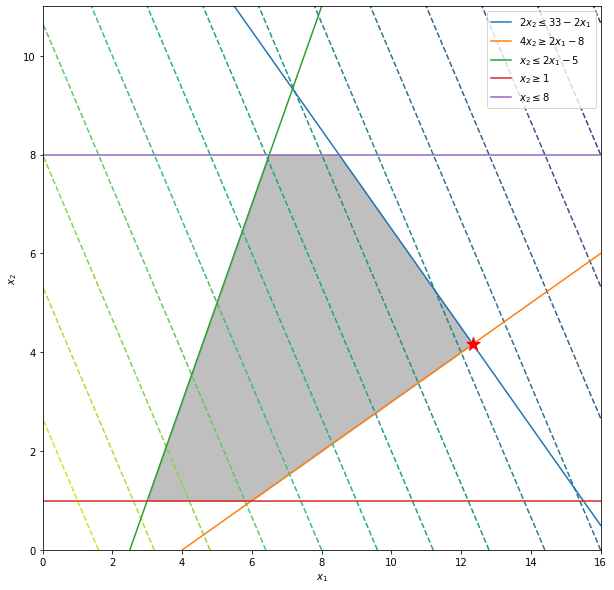

In [44]:
plt.contour(X,Y,Z, linestyles = 'dashed', levels = 20)
plt.axis([0,16,0,11])
plt.xlabel(r"$x_1$"); plt.ylabel(r"$x_2$")

y1 = (-2*linspace+33)/2
y2 = (2*linspace-8)/4
y3 = 2*linspace-5
y4 = (0*linspace)+1
y5 = (0*linspace)+8

lines = [y1,y2,y3,y4,y5]
lineEqs = [r"$2x_2 \leq 33-2x_1$",r"$4x_2 \geq 2x_1 - 8$",r"$x_2 \leq 2x_1 - 5$",r"$x_2\geq 1$",r"$x_2\leq 8$"]

for g,i in enumerate(lines):    
    plt.plot(linspace, i, label=lineEqs[g])

# fill_between works by defining nodes of a shape.
y6 = np.minimum(np.minimum(y1, y3),np.minimum(y1,y5)) # Upper nodes.
y7 = np.maximum(y2, y4) # Lower nodes.
plt.scatter(*node0, marker = "*", c = "r", s = 200, zorder = 10) # Based on the above.
plt.fill_between(linspace, y6, y7, where = y6>y7, color = "grey", alpha = 0.5)
plt.legend();

### Example 7.6 (Quadratic Program)
*Recall Figure 7.4, solving for a constrained optimization problem using lagrangian multipliers, where a solution space is shaded with a grey box.*

In [45]:
f = (np.dot((1/2)*np.array([x,y]),np.dot(np.vstack([[2,1],[1,4]]),np.vstack([x,y]))) - np.dot(np.array([5,3]),np.vstack([x,y])))[0]
f
fLam = lambdify('x,y',f)

0.5*x*(2*x + y) - 5*x + 0.5*y*(x + 4*y) - 3*y

Rather than solving for the nodes as in the last example, we know we are solving for one side, which we can see is the right side of the square. 

In [46]:
potentialSols = np.hstack([np.vstack(np.linspace(1,1,100)),np.vstack(np.linspace(-1,1,100))])
potentialSols[:5]

array([[ 1.        , -1.        ],
       [ 1.        , -0.97979798],
       [ 1.        , -0.95959596],
       [ 1.        , -0.93939394],
       [ 1.        , -0.91919192]])

In [47]:
objectiveSols = np.vstack([fLam(i[0],i[1]) for i in potentialSols])
objectiveSols[:5]

array([[ 0.        ],
       [-0.12039588],
       [-0.23915927],
       [-0.35629017],
       [-0.47178859]])

In [48]:
np.where(objectiveSols == np.amin(objectiveSols))

(array([74]), array([0]))

In [49]:
potentialSols[74]

array([1.        , 0.49494949])

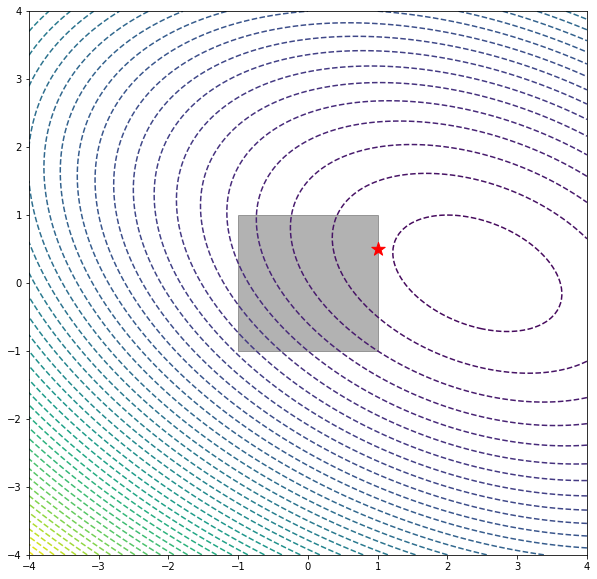

In [50]:
linspace = np.linspace(-scale3D,scale3D,n) 
X,Y = np.meshgrid(linspace,linspace)
Z = fLam(X,Y)
plt.contour(X,Y,Z, levels = 50, linestyles = 'dashed')
plt.fill_between(np.linspace(-1,1,100),np.linspace(-1,-1,100),np.linspace(1,1,100), alpha = .3, ec = 'k', fc = 'k')
plt.scatter(*potentialSols[74],marker="*",c="r",s=200);

#### 7.3.3 Legendre-Fenchel Transform and Convex Conjugate
### Example 7.7 (Convex Conjugates)
*Constructing a convex conjugate for a sample function.*
### Example 7.8 
*Deriving the convex conjugate for a loss function.*
### Example 7.9
*Book provides connection between Lagrange multipliers and the convex conjugate.*

##### The Legendre Transform

In [51]:
b = 1.5
d = .5
f = x**2
fLam = lambdify('x',f)
f
fLam(1)

x**2

1

In [52]:
f1 = diff(f)
f1Lam = lambdify('x', f1)
f1
f1Lam(1)

2*x

2

(7.54) Recall that we are able to describe convex functions by their supporting hyperplanes. 

Consider these tangents the linear taylor expansions at each point.

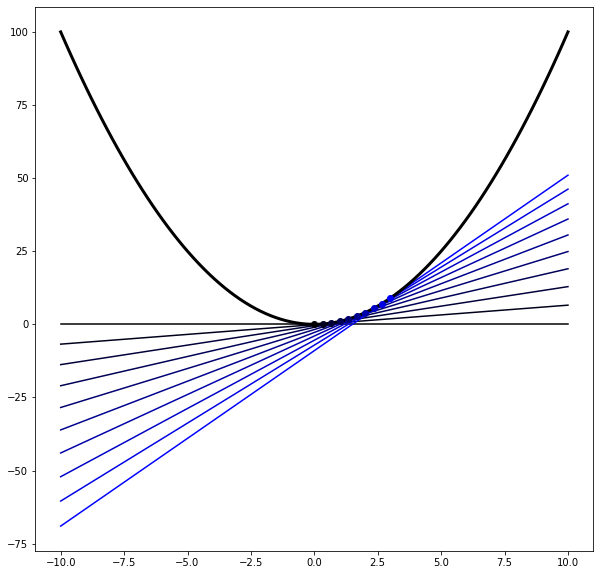

In [53]:
linspace = np.linspace(-10,10,100)
linspace2 = np.linspace(0,3,10) 
interp = interp1d([0,3],[0,1]) # Interpolation for color mapping.
eqLine = lambda m, x, x0, y0: m(x0)*(x-x0)+y0
for i in linspace2:
    point = [i,fLam(i)]
    plt.plot(linspace, eqLine(f1Lam, linspace, *point), c = [0,0,interp(i)])
    plt.scatter(*point, c = np.vstack([0,0,interp(i)]).T, zorder=10)
plt.plot(linspace,fLam(linspace), c = 'k', lw = 3);

We can plot the y-intercepts of these lines as in (7.55).

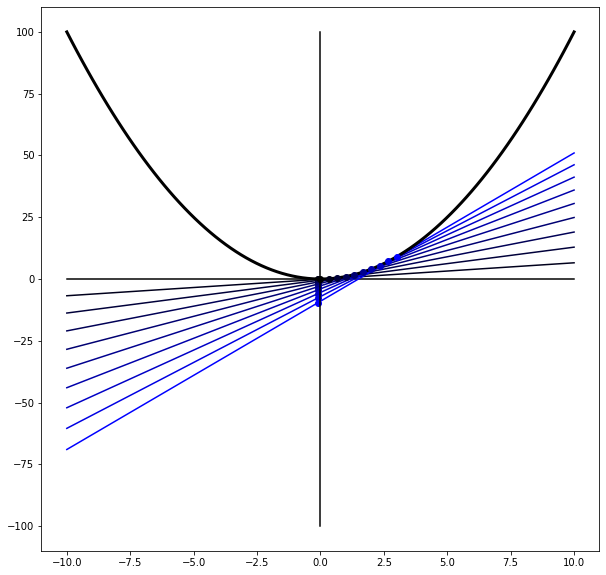

In [54]:
linspace = np.linspace(-10,10,100)
linspace2 = np.linspace(0,3,10) 
m = interp1d([0,3],[0,1]) # Interpolation for color mapping.

for i in linspace2:
    point = [i,fLam(i)]
    plt.plot(linspace, eqLine(f1Lam, linspace, *point), c = [0,0,m(i)])
    plt.scatter(*point, c = np.vstack([0,0,m(i)]).T, zorder=10)
    # Plotting the y-intercepts.
    coords = np.hstack([np.vstack(linspace),np.vstack(eqLine(f1Lam, linspace, *point))])
    plt.scatter(*coords[(np.abs(coords[:,0]-0)).argmin()], c = np.vstack([0,0,m(i)]).T)
    
plt.plot(linspace,fLam(linspace), c = 'k', lw = 3)
plt.plot(np.linspace(0,0,10),np.linspace(-100,100,10), c = "k");

The convex conjugate is as the book states, the slope*point-f(point), or $f^*(s) := s(x_0) - f(x_0)$. Using the above, this can be plotted as the x values of the tangent with our initial function, and the y values of our tangent with the graph. 

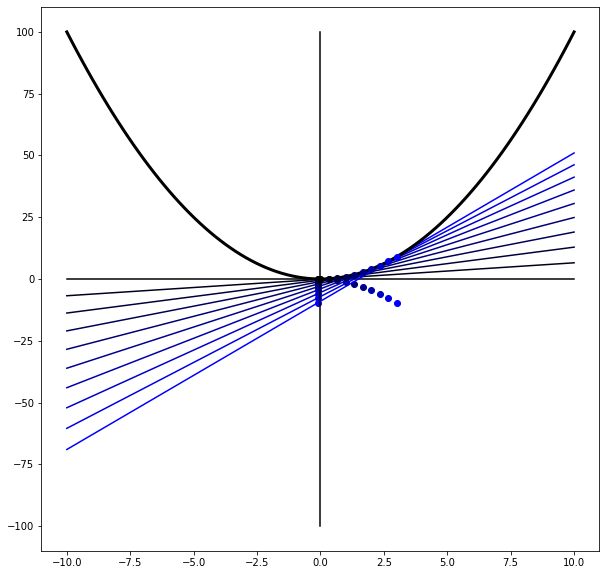

In [55]:
linspace = np.linspace(-10,10,100)
linspace2 = np.linspace(0,3,10) 
m = interp1d([0,3],[0,1]) # Interpolation for color mapping.

for i in linspace2:
    point = [i,fLam(i)]
    plt.plot(linspace, eqLine(f1Lam, linspace, *point), c = [0,0,m(i)])
    plt.scatter(*point, c = np.vstack([0,0,m(i)]).T, zorder=10)
    # Plotting the y-intercepts.
    coords = np.hstack([np.vstack(linspace),np.vstack(eqLine(f1Lam, linspace, *point))])
    plt.scatter(*coords[(np.abs(coords[:,0]-0)).argmin()], c = np.vstack([0,0,m(i)]).T)
    # Plotting the convex conjugate.
    plt.scatter(point[0],coords[(np.abs(coords[:,0]-0)).argmin()][1], c = np.vstack([0,0,m(i)]).T)
    
plt.plot(linspace,fLam(linspace), c = 'k', lw = 3)
plt.plot(np.linspace(0,0,10),np.linspace(-100,100,10), c = "k");

Considering that "-c", the y-intercept, changes with our point, "$x_0$", we consider this a function of s, the tangent.

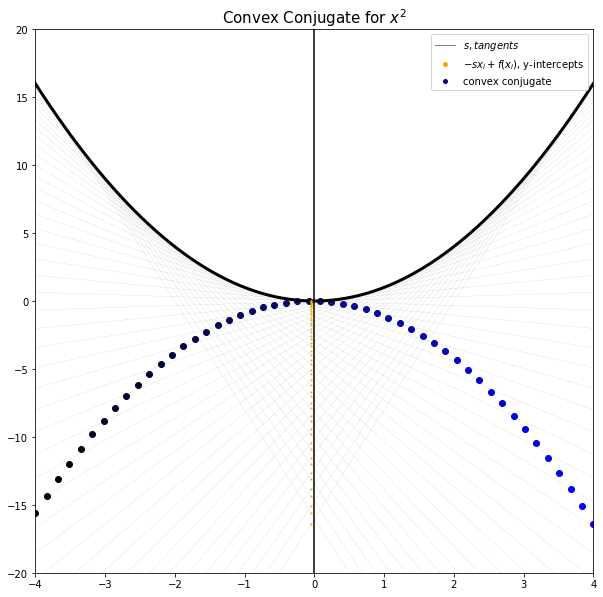

In [56]:
linspace = np.linspace(-5,5,100)
linspace2 = np.linspace(-4,4,50) 
m = interp1d([-4,4],[0,1]) # Interpolation for color mapping.
eqLine = lambda m, x, x0, y0: m*(x-x0)+y0

for i in linspace2:
    currY = fLam(i)
    currSlope = f1Lam(i)
    
    # Plotting s, the tangents.
    plt.plot(linspace, eqLine(currSlope, linspace, i, currY), c = "grey", lw = .1)
    
    # Plotting -sx_i + f(x_i), the y-intercepts.
    coords = np.hstack([np.vstack(linspace),np.vstack(eqLine(currSlope, linspace, i, currY))])
    plt.scatter(*coords[(np.abs(coords[:,0]-0)).argmin()], c = "orange", s = 1, zorder=10)
    
    # Plotting -c, f*(s), the convex conjugate.
    plt.scatter(i,coords[(np.abs(coords[:,0]-0)).argmin()][1], c = np.vstack([0,0,m(i)]).T)
    
plt.plot(linspace,fLam(linspace), c = 'k', lw = 3)
plt.plot(np.linspace(0,0,10),np.linspace(-100,100,10), c = "k")
plt.axis([-4,4,-20,20])

customLegend = [Line2D([0],[0], color = "grey", lw = 1, label = r"$s, tangents$"),
                Line2D([0],[0], marker = 'o', color = "w", label = r"$-sx_i+f(x_i)$, y-intercepts",
                      markerfacecolor = 'orange'),
                Line2D([0],[0], marker = 'o', color = "w", label = "convex conjugate",
                      markerfacecolor = 'navy')]

plt.legend(handles = customLegend, loc=1)
plt.title(r'Convex Conjugate for $x^2.$', size = 15);

Guidance from http://www.onmyphd.com/?p=legendre.fenchel.transform for the above.